In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations

from typing import *  # pyright: ignore
from decimal import Decimal
from fractions import Fraction

import numpy as np
from numpy.typing import NDArray as _NDArray

_T = TypeVar("_T", bound=Any)
NDArray: TypeAlias = _NDArray[_T]
NestedSequence: TypeAlias = "Sequence[_T | NestedSequence[_T]]"

Scalar: TypeAlias = float | int | Decimal | Fraction | np.number[Any]
ScalarT = TypeVar("ScalarT", bound=Scalar)


ArrayLike: TypeAlias = "NDArray[ScalarT] | NestedSequence[ScalarT]"

In [3]:
import metpy.units
import metpy.calc

import pint
from pint.registry import Quantity, Unit
from pint.facets.plain import PlainQuantity, PlainUnit


if TYPE_CHECKING:
    from literal_unit import LiteralUnit  # pyright: ignore
else:
    LiteralUnit = str

In [4]:
import pint.registry


ureg = pint.UnitRegistry()


def unit(x: Any):
    return ureg(x).units


# ureg = pint.registry.GenericUnitRegistry()
ureg.default_format = ".3f~P"

# • [time]
s = unit("second")
min_ = unit("minute")
hr = unit("hour")


# • [temperature]
K = unit("kelvin")
C = unit("celsius")
F = unit("fahrenheit")


# • [length]
m = unit("meter")
km = unit("kilometer")

in_ = unit("inch")
ft = unit("foot")
mi = unit("mile")


# • pressure
Pa = unit("pascal")
hPa = unit("hectopascal")
kPa = unit("kilopascal")
mbar = unit("millibar")

# • energy
J = unit("joule")
kJ = unit("kilojoule")
cal = unit("calorie")
kcal = unit("kilocalorie")
mol = unit("mole")

# - [mass]
kg = unit("kilogram")


# - angle
deg = unit("degree")
rad = unit("radian")


dimensionless = unit("dimensionless")
# - speed
mps = m / s
kph = km / hr
mph = mi / hr
kts = unit("knot")

# - image processing
px = unit("pixel")
dpi = unit("dot/inch")
ppi = unit("pixel/inch")

In [5]:
from src.mesoformer.utils import as_any_array


def unit(x: Any):
    return ureg(x).units


def isscaler(x: Any) -> TypeGuard[Scalar]:
    return np.isscalar(x.magnitude if isinstance(x, Quantity) else x)


@overload
def quantity(
    x: ScalarT,
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[ScalarT]:
    ...


@overload
def quantity(
    x: ArrayLike[ScalarT],
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[NDArray[ScalarT]]:  # type: ignore
    ...


def quantity(
    x: ScalarT | ArrayLike[ScalarT],
    unit: pint.Unit | Quantity | LiteralUnit | PlainUnit | PlainQuantity = dimensionless,
) -> PlainQuantity[ScalarT] | PlainQuantity[NDArray[ScalarT]]:  # type: ignore
    unit = ureg(unit) if isinstance(unit, str) else unit
    return (x if isscaler(x) else np.asanyarray(x)) * unit  # type: ignore


@as_any_array(np.float32)
def normalize(x: NDArray[np.number]) -> NDArray[np.float_]:
    return (x - x.min(keepdims=True)) / (x.max(keepdims=True) - x.min(keepdims=True))


@ureg.wraps(dimensionless, hPa)
def log_p(x) -> Quantity:
    return np.log(x)

In [6]:
EARTH_GRAVITY = g = quantity(9.80665, m / s**2)
""">>> EARTH_GRAVITY `little g`"""
GRAVITATIONAL_CONSTANT = G = quantity(6.67408e-11, m**3 / kg / s**2)
"""`big G`""" ""
EARTH_RADIUS = Re = quantity(6371008.7714, m)
GEOCENTRIC_GRAVITATIONAL_CONSTANT = GM = quantity(3986005e8, m**3 / s**2)
EARTH_MASS = Me = GEOCENTRIC_GRAVITATIONAL_CONSTANT / GRAVITATIONAL_CONSTANT


ABSOLUTE_ZERO = K0 = quantity(-273.15, K)
MOLAR_GAS_CONSTANT = R = quantity(8.314462618, J / mol / K)


STANDARD_TEMPERATURE = t0 = quantity(288.0, K)
"""Standard temperature at sea level."""
STANDARD_PRESSURE = p0 = quantity(1013.25, hPa)
"""Standard pressure at sea level."""
STANDARD_LAPSE_RATE = gamma = quantity(6.5, K / km)
"""Standard lapse rate."""

MOLAR_GAS_CONSTANT = R = quantity(8.314462618, J / mol / K)
DRY_AIR_MOLECULAR_WEIGHT_RATIO = Md = quantity(28.96546e-3, kg / mol)

# Dry air

DRY_AIR_GAS_CONST = Rd = quantity(R / Md)
# Md = dry_air_molecular_weight = units.Quantity(28.96546e-3, 'kg / mol')
# Rd = dry_air_gas_constant = R / Md
DRY_AIR_SPECIFIC_HEAT_RATIO = dash_r = quantity(1.4)
DRY_AIR_SPECIFIC_HEAT_PRESSURE = Cp_d = quantity(dash_r * Rd / (dash_r - 1))
DRY_AIR_SPECIFIC_HEAT_VOLUME = Cv_d = quantity(Cp_d / dash_r)
P0 = pot_temp_ref_press = 1000.0 * mbar
DRY_AIR_DENSITY_STP = rho_d = quantity(P0 / (Rd * -K0)).to(kg / m**3)
# rho_d = dry_air_density_stp = quantity(P0 / (Rd * -K0)).to("kg / m^3")
# Dry air
DRY_AIR_MOLECULAR_WEIGHT_RATIO = Md = 28.96546e-3 * kg / mol
DRY_AIR_GAS_CONST = Rd = R / Md
# Md = dry_air_molecular_weight = units.Quantity(28.96546e-3, 'kg / mol')
# Rd = dry_air_gas_constant = R / Md
# dry_air_spec_heat_ratio = 1.4 * dimensionless
# Cp_d = dry_air_spec_heat_press = dry_air_spec_heat_ratio * Rd / (dry_air_spec_heat_ratio - 1)
# Cv_d = dry_air_spec_heat_vol = Cp_d / dry_air_spec_heat_ratio
# P0 = pot_temp_ref_press = 1000.0 * mbar
# rho_d = dry_air_density_stp = quantity(P0 / (Rd * -K0)).to(kg / m**3)
# Cp_d, Cv_d, _CP, Cv_d / Cp_d

In [7]:
from numbers import Number

Numeric = Number | np.number[Any] | float | int | Decimal | Fraction


def pressure2height(pressure: PlainQuantity[NDArray[Any]]) -> PlainQuantity[float]:
    return t0 / gamma * (1 - (pressure / p0) ** (Rd * gamma / g))


def height2pressure(height: PlainQuantity[float | int] | NDArray) -> PlainQuantity[float]:
    return p0 * (1 - (gamma / t0) * height) ** (g / (Rd * gamma))


STANDARD_ATMOSPHERE = p_levels = [1013.25, *map(float, range(1000, 25 - 11, -25))]
# levels = [850.0, 700.0, 500.0, 300.0]
assert np.all(pressure2height(p_levels * hPa) == metpy.calc.pressure_to_height_std(p_levels * metpy.units.units.hPa))

heights = pressure2height(p_levels * hPa)
assert np.all(
    metpy.calc.height_to_pressure_std(metpy.calc.pressure_to_height_std(p_levels * metpy.units.units.hPa))
    == height2pressure(pressure2height(p_levels * hPa))
)

In [8]:
import matplotlib.pyplot as plt

STANDARD_ATMOSPHERE_LEVELS = p_levels = quantity([1013.25, *map(float, range(1000, 25 - 11, -25))], hPa)
p_levels
# ax.line(p_levels.m)

Magnitude,[1013.25 1000.0 975.0 950.0 925.0 900.0 875.0 850.0 825.0 800.0 775.0 750.0 725.0 700.0 675.0 650.0 625.0 600.0 575.0 550.0 525.0 500.0 475.0 450.0 425.0 400.0 375.0 350.0 325.0 300.0 275.0 250.0 225.0 200.0 175.0 150.0 125.0 100.0 75.0 50.0 25.0]
Units,hPa


In [9]:
STANDARD_HEIGHTS = heights = pressure2height(p_levels)
heights

Magnitude,[-0.0 0.11082463191827029 0.3232070008045167 0.5400457639046125 0.7615554828072729 0.9879671974242934 1.2195301902939262 1.456513996284988 1.6992107001633152 1.947937573358983 2.2030401123457213 2.464895554945448 2.7339169684442526 3.010558025783667 3.2953186148078832 3.588751462706512 3.891470006302659 4.204157802769398 4.527579860480632 4.862596384290676 5.21017958563185 5.571434423209206 5.947624441471662 6.340204302290991 6.750861224061164 7.181568453172953 7.634655260977472 8.112900062019325 8.619656564404572 9.159028242671468 9.736115444461602 10.357375151717509 11.031162002595584 11.768573960438637 12.584837720144355 13.501714709781766 14.55200350500616 15.788845929720818 17.307853736092152 19.312405402539174 22.400622183232443]
Units,km


In [10]:
import pandas as pd
import matplotlib.pyplot as plt

ureg.setup_matplotlib()
plot_kwargs: dict[str, Any] = dict(marker=".", linestyle="-", linewidth=0.75)


def plot(x, y, legend, ax=None, **kwargs):
    ax = ax or plt.gca()
    ax.plot(x, y, **(plot_kwargs | kwargs))
    ax.legend([legend] if isinstance(legend, str) else legend)

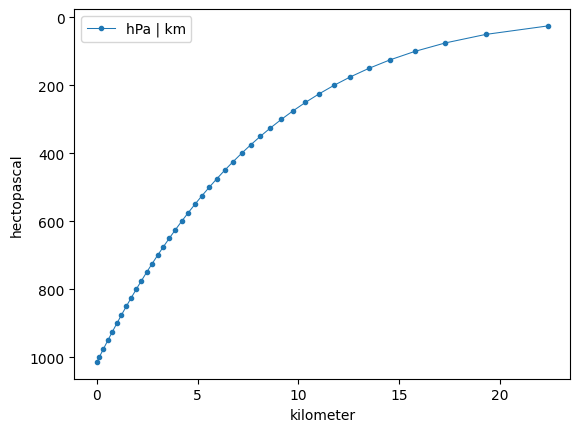

In [13]:
ax = plt.gca()
ax.invert_yaxis()

plot(heights, p_levels, "hPa | km", ax=ax)
plt.show()

NameError: name 'data_frame' is not defined

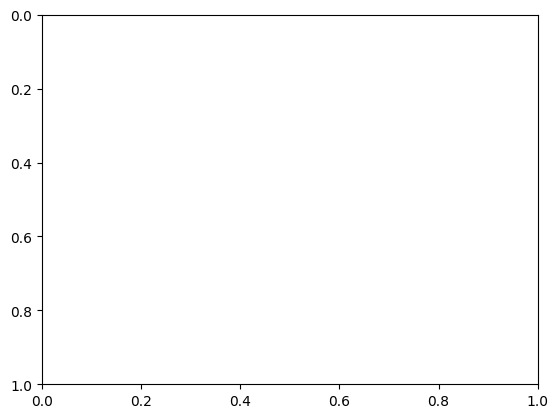

In [12]:
import matplotlib.pyplot as plt



ax = plt.axes()
ax.invert_yaxis()
plot_kwargs: dict[str, Any] = dict(marker=".", linestyle="-", linewidth=0.75)

df = data_frame(height=heights, pressure=p_levels)
ax.yaxis.set_units("hPa")
ax.xaxis.set_units("m")
df.plot.line(
    x="height",
    y="pressure",
    ax=ax,
    **plot_kwargs,
)


plt.show()

In [ ]:
import pandas as pd

ax = plt.axes()
ax.invert_yaxis()

norm = X = (normalize(p_levels) + 1) * dimensionless  # type: ignore
scale = Y = normalize(log_p(p_levels))[::-1] + 1 * dimensionless  # type: ignore


df = data_frame(scale=scale, levels=p_levels)
df.plot.line(x="scale", y="levels", ax=ax, label="scale", **plot_kwargs)

df.iloc[::4]

In [ ]:
p_targets = quantity([p0.m, 850, 700, 500, 300], hPa)
mask = np.isin(p_levels, p_targets)  # type: ignore

scale[mask]

# (pressure2height(p_targets) * ((scale[mask] / 1.25) + 1) * 200)